In [1]:
import os
import logging


import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import dill

import torch
import pyro
import pyro.distributions as dist
from pyro.infer.autoguide import AutoNormal, AutoMultivariateNormal, AutoDelta
from pyro.infer import SVI, Trace_ELBO, Predictive
from pyro.optim import Adam
from chirho.indexed.handlers import IndexPlatesMessenger
from chirho.counterfactual.handlers import MultiWorldCounterfactual
from chirho.indexed.ops import IndexSet, gather, indices_of
from chirho.interventional.handlers import do
from chirho.observational.handlers import condition


from cities.utils.data_grabber import (DataGrabber, list_available_features, list_tensed_features, list_interventions, list_outcomes)
from cities.utils.cleaning_utils import check_if_tensed, find_repo_root
from cities.modeling.model_interactions import cities_model_interactions as model
from cities.modeling.model_interactions import InteractionsModel
from cities.modeling.modeling_utils import (prep_data_for_interaction_inference, train_interactions_model)
from cities.utils.cleaning_utils import find_repo_root


In [2]:
features = list_available_features()
tensed_features = list_tensed_features()
interventions = list_interventions()
outcomes = list_outcomes()

print(features)
print(tensed_features)
print(interventions)
print(outcomes)

['ethnic_composition', 'gdp', 'industry', 'industry_accommodation_food_services_total', 'industry_admin_support_services_total', 'industry_agriculture_total', 'industry_arts_recreation_total', 'industry_construction_total', 'industry_educational_services_total', 'industry_finance_insurance_total', 'industry_healthcare_social_services_total', 'industry_information_total', 'industry_management_enterprises_total', 'industry_manufacturing_total', 'industry_mining_total', 'industry_other_services_total', 'industry_professional_services_total', 'industry_public_administration_total', 'industry_real_estate_total', 'industry_retail_trade_total', 'industry_transportation_warehousing_total', 'industry_utilities_total', 'industry_wholesale_trade_total', 'population', 'spending_HHS', 'spending_commerce', 'spending_transportation', 'transport', 'unemployment_rate', 'urbanization']
['gdp', 'industry_accommodation_food_services_total', 'industry_admin_support_services_total', 'industry_agriculture_to

In [3]:
def model_testing(
    N_t,
    N_cov,
    N_s,
    N_u,
    N_obs,
    state_index_sparse,
    state_index,
    time_index,
    unit_index,
    leeway=0.2,
):
    Y_bias = pyro.sample("Y_bias", dist.Normal(0, leeway))
    T_bias = pyro.sample("T_bias", dist.Normal(0, leeway))

    weight_TY = pyro.sample("weight_TY", dist.Normal(0, leeway))

    sigma_T = pyro.sample("sigma_T", dist.Exponential(1))
    sigma_Y = pyro.sample("sigma_Y", dist.Exponential(1))

    observations_plate = pyro.plate("observations_plate", N_obs, dim=-1)

    counties_plate = pyro.plate("counties_plate", N_u, dim=-2)
    states_plate = pyro.plate("states_plate", N_s, dim=-3)
    covariates_plate = pyro.plate("covariates_plate", N_cov, dim=-4)
    time_plate = pyro.plate("time_plate", N_t, dim=-5)
    print("Nt", N_t)

    with covariates_plate:
        X_bias = pyro.sample("X_bias", dist.Normal(0, leeway)).squeeze()
        sigma_X = pyro.sample("sigma_X", dist.Exponential(1)).squeeze()
        weight_XT = pyro.sample("weight_XT", dist.Normal(0, leeway)).squeeze()
        weight_XY = pyro.sample("weight_XY", dist.Normal(0, leeway)).squeeze()

    with states_plate:
        weight_UsT = pyro.sample("weight_UsT", dist.Normal(0, leeway)).squeeze()
        weight_UsY = pyro.sample("weight_UsY", dist.Normal(0, leeway)).squeeze()

        with covariates_plate:
            weight_UsX = pyro.sample("weight_UsX", dist.Normal(0, leeway)).squeeze()

    with time_plate:
        weight_UtTfull = pyro.sample("weight_UtTfull", dist.Normal(0, leeway))
        print(weight_UtTfull.shape)
        weight_UtT = pyro.sample("weight_UtT", dist.Normal(0, leeway)).squeeze()
        print(" model wUtT", weight_UtT.shape)
        weight_UtY = pyro.sample("weight_UtY", dist.Normal(0, leeway)).squeeze()

    with counties_plate:
        UsX_weight_selected = weight_UsX.squeeze().T.squeeze()[state_index_sparse]
        X_means = torch.einsum("c,uc->uc", X_bias, UsX_weight_selected)
        X = pyro.sample("X", dist.Normal(X_means, sigma_X)).squeeze()

    XT_weighted = torch.einsum("uc, c -> u", X, weight_XT)
    XY_weighted = torch.einsum("uc, c -> u", X, weight_XY)

    with observations_plate:
        T_mean = (
            T_bias
            + weight_UtT[time_index]
            + weight_UsT[state_index]
            + XT_weighted[unit_index]
        )

        T = pyro.sample("T", dist.Normal(T_mean, sigma_T))

        Y_mean = (
            Y_bias
            + weight_UtY[time_index]
            + weight_UsY[state_index]
            + weight_TY * T
            + XY_weighted[unit_index]
        )

        Y = pyro.sample("Y", dist.Normal(Y_mean, sigma_Y))

    return Y 



In [4]:
# this example will be generalized into a 
# general insight class
# mostly used for quality checks
# and country-level insights

outcome_dataset='industry_transportation_warehousing_total'
intervention_dataset='spending_transportation'

dg = DataGrabber()
dg.get_features_std_long([intervention_dataset, outcome_dataset])

root = find_repo_root()
log_dir = os.path.join(root, "data", "model_outputs/general_insights")
log_file_path = os.path.join(log_dir, ".general_insights.log")
os.makedirs(log_dir, exist_ok=True)

logging.basicConfig(filename=log_file_path, filemode="w", 
                format="%(asctime)s → %(name)s → %(levelname)s: %(message)s",
                datefmt="%Y-%m-%d %H:%M:%S", level=logging.INFO)

intervention_variable = dg.std_long[intervention_dataset].columns[-1]

loaded_data = {}
model_args = {}
loaded_guides = {}
predictives = {}
samples = {}
tau_samples = {}
#for forward_shift in [1, 2, 3]:

forward_shift = 1
# load and prep data
loaded_data[forward_shift] =  prep_data_for_interaction_inference(
        outcome_dataset=outcome_dataset,
intervention_dataset=intervention_dataset,
intervention_variable=intervention_variable,
forward_shift=forward_shift, 
    )

print(loaded_data[forward_shift].keys())

model_args[forward_shift] = (
        loaded_data[forward_shift]['N_t'],
        loaded_data[forward_shift]['N_cov'],
        loaded_data[forward_shift]['N_s'],
        loaded_data[forward_shift]['N_u'],
        loaded_data[forward_shift]['N_obs'],
        loaded_data[forward_shift]['state_index_sparse'],
        loaded_data[forward_shift]['state_index'],
        loaded_data[forward_shift]['time_index'],
        loaded_data[forward_shift]['unit_index'],
    )

print("ntdata", loaded_data[forward_shift]['N_t'])

model =  pyro.condition(
            model_testing,
            data={"T": loaded_data[forward_shift]['intervention'], "Y": loaded_data[forward_shift]['y'], 
                  "X": loaded_data[forward_shift]['covariates_sparse']},
        )


# find and load the guides
guide_name = (f"{intervention_dataset}_{outcome_dataset}_{forward_shift}")
print(guide_name)
file_path = os.path.join(root, "data/model_guides", f"{guide_name}_guide.pkl")
print(file_path)
with open(file_path, "rb") as file:
    loaded_guides[forward_shift] = dill.load(file)

print("predictive")

predictives[forward_shift] = Predictive(model, guide=loaded_guides[forward_shift], num_samples=500, parallel=False)

print("sampling")
samples[forward_shift] = predictives[forward_shift](*model_args[forward_shift])



dict_keys(['N_t', 'N_cov', 'N_s', 'N_u', 'N_obs', 'unit_index', 'state_index', 'time_index', 'unit_index_sparse', 'state_index_sparse', 'covariates', 'covariates_sparse', 'intervention', 'y'])
ntdata 11
spending_transportation_industry_transportation_warehousing_total_1
/home/rafal/s78projects/cities/data/model_guides/spending_transportation_industry_transportation_warehousing_total_1_guide.pkl
predictive
sampling
Nt 11
 model wUtT torch.Size([11])
Nt 11
 model wUtT torch.Size([11])
Nt 11
 model wUtT torch.Size([10])


IndexError: index 10 is out of bounds for dimension 0 with size 10

In [ ]:
    # tau_samples[forward_shift] = samples['weight_TY'].squeeze().detach().numpy()

    # plt.hist(tau_samples,bins = 70)
    # plt.axvline(x=tau_samples.mean(), color='red', linestyle='dashed', linewidth=2, label=f'mean = {tau_samples.mean():.3f}')
    # plt.title(f"tau for {intervention_dataset} on {outcome_dataset} at {forward_shift} steps forward shift")
    # plt.legend()
    # plt.show()




In [22]:



loaded_data =  prep_data_for_interaction_inference(
            outcome_dataset=outcome_dataset,
    intervention_dataset=intervention_dataset,
    intervention_variable=intervention_variable,
    forward_shift=1, 
        )

print(loaded_data.keys())

root = find_repo_root()

guide_name = (
            f"{intervention_dataset}_{outcome_dataset}_{forward_shift}"
        )

file_path = os.path.join(
            root, "data/model_guides", f"{guide_name}_guide.pkl"
        )

print(file_path)
with open(file_path, "rb") as file:
        loaded_guide = dill.load(file)

model_args = (
            loaded_data['N_t'],
            loaded_data['N_cov'],
            loaded_data['N_s'],
            loaded_data['N_u'],
            loaded_data['N_obs'],
            loaded_data['state_index_sparse'],
            loaded_data['state_index'],
            loaded_data['time_index'],
            loaded_data['unit_index'],
        )


print("N_t", loaded_data['N_t'])

predictive = Predictive(model, guide=loaded_guide, num_samples=500, parallel=False)
samples = predictive(*model_args)



# tau_samples = samples['weight_TY'].squeeze().detach().numpy()

# plt.hist(tau_samples,bins = 70)
# plt.axvline(x=tau_samples.mean(), color='red', linestyle='dashed', linewidth=2, label=f'mean = {tau_samples.mean():.3f}')
# plt.title("tau posterior (structured latent confounders model)")
# plt.legend()
# plt.show()


dict_keys(['N_t', 'N_cov', 'N_s', 'N_u', 'N_obs', 'unit_index', 'state_index', 'time_index', 'unit_index_sparse', 'state_index_sparse', 'covariates', 'covariates_sparse', 'intervention', 'y'])
/home/rafal/s78projects/cities/data/model_guides/spending_transportation_industry_transportation_warehousing_total_1_guide.pkl
N_t 11


IndexError: index 10 is out of bounds for dimension 0 with size 10

In [2]:
unemployment_commerce_2 = InteractionsModel(outcome_dataset='unemployment_rate',
    intervention_dataset='spending_commerce',
    intervention_variable='total_obligated_amount',
    forward_shift = 2,
    num_iterations= 2500)

['N_cov', 'N_obs', 'N_s', 'N_t', 'N_u', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'covariates', 'covariates_sparse', 'forward_shift', 'intervention', 'intervention_dataset', 'intervention_variable', 'model', 'model_args', 'model_conditioned', 'model_rendering', 'num_iterations', 'outcome_dataset', 'plot_loss', 'root', 'save_guide', 'state_index', 'state_index_sparse', 'time_index', 'train_interactions_model', 'unit_index', 'unit_index_sparse', 'y']


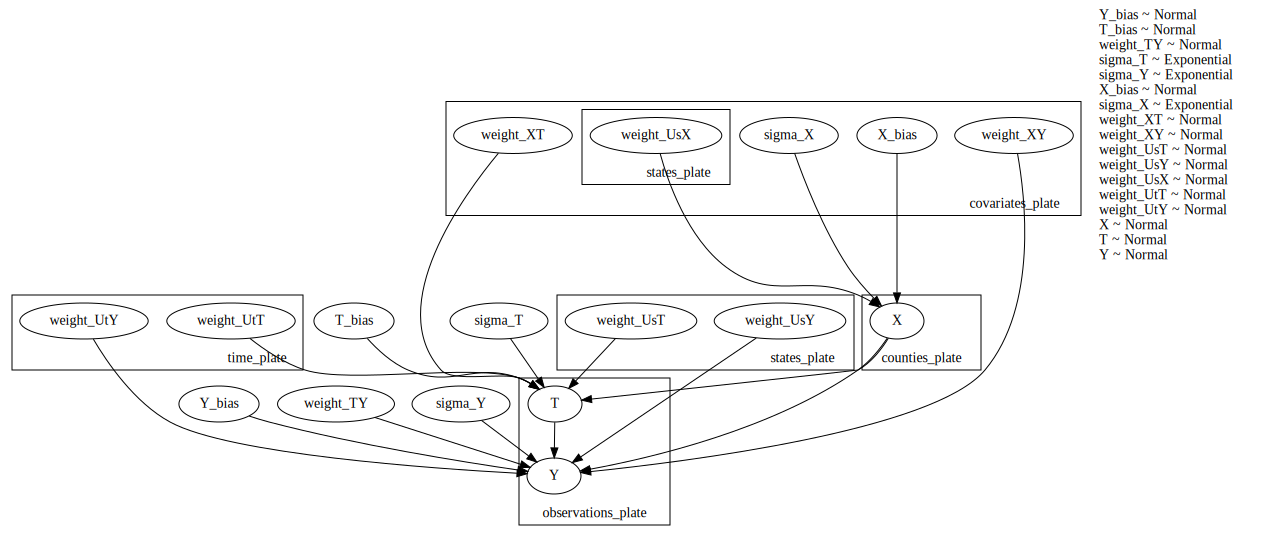

In [3]:

print(dir(unemployment_commerce_2))
display(unemployment_commerce_2.model_rendering)

In [4]:
unemployment_commerce_2.train_interactions_model()

[iteration 0001] loss: 101181.3819
[iteration 0101] loss: 2751.3058
[iteration 0201] loss: -61312.6889
[iteration 0301] loss: -77332.9386
[iteration 0401] loss: -78156.5118
[iteration 0501] loss: -79800.3219
[iteration 0601] loss: -80529.4612
[iteration 0701] loss: -80462.0153
[iteration 0801] loss: -80487.3735
[iteration 0901] loss: -80965.6108
[iteration 1001] loss: -80955.0966
[iteration 1101] loss: -81057.1373
[iteration 1201] loss: -81077.0996
[iteration 1301] loss: -81067.1584
[iteration 1401] loss: -81126.9356
[iteration 1501] loss: -81091.3717
[iteration 1601] loss: -81149.2080
[iteration 1701] loss: -80957.1962
[iteration 1801] loss: -81127.4050
[iteration 1901] loss: -81085.6864
[iteration 2001] loss: -81091.9705
[iteration 2101] loss: -81193.6178
[iteration 2201] loss: -81068.2094
[iteration 2301] loss: -81193.7841
[iteration 2401] loss: -81138.1209


In [5]:
# note: a saved guide with num_iterations = 2500 is still around 200 kb

unemployment_commerce_2.save_guide()

Guide spending_commerce_unemployment_rate_2 has been saved.


The above completes a brief use case of `InteractionsModel`. What follows is a short example of dowstream use (to be streamlined and wrapped in a class in a separate PR)

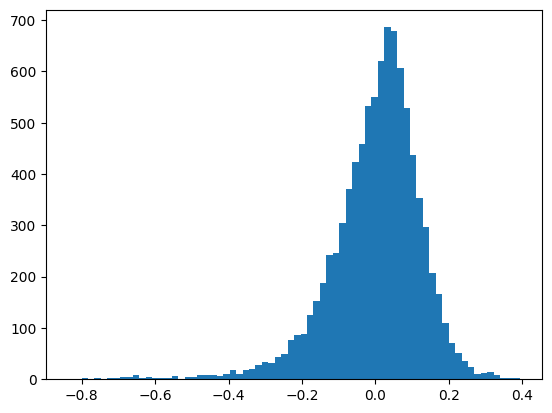

In [11]:
# plot residuals
y = loaded_data['y']
predictions = samples['Y'].squeeze().T
mean_predictions = torch.mean(predictions, dim = 1)

plt.hist(mean_predictions -y, bins=70)
plt.show()

In [12]:
observed_mean = torch.mean(y)
tss = torch.sum((y - observed_mean) ** 2)
print("tss", tss)
rss = torch.sum((y - mean_predictions) ** 2)
print("rss", rss)
r_squared = 1 - (rss / tss)
print("r_squared", r_squared)

tss tensor(206.3684)
rss tensor(144.1228)
r_squared tensor(0.3016)
